In [1]:
import tensorflow as tf
from keras.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization, RandomFlip, RandomRotation
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from albumentations import RandomCrop, HorizontalFlip, VerticalFlip, RandomRotate90
from ResNet import ResNet34

2023-11-09 11:45:23.589210: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-09 11:45:23.589234: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-09 11:45:23.590361: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-09 11:45:23.690398: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train_img_path = './dataset/train/'
val_img_path = './dataset/val/'
test_img_path = './dataset/test/'

CLASS_NAMES = ["benign", "malignant", "normal"]

CONFIGURATION = {
    "N_FILTER":16,
    "IM_SIZE":256,
    "BATCH_SIZE":8,
    "N_EPOCHS":50,
    "SHUFFLE_SIZE":32,
    "N_DENSE_1":1024,
    "N_DENSE_2":128,
    "NUM_CLASSES":3,
    "LEARNING_RATE":0.001,
}

# Data Import

In [3]:
train_begign_img_path = './dataset/train_benign/img/'
train_malig_img_path = './dataset/train_malignant/img/'
train_normal_img_path = './dataset/train_normal/img/'

val_begign_img_path = './dataset/val_benign/img/'
val_malig_img_path = './dataset/val_malignant/img/'
val_normal_img_path = './dataset/val_normal/img/'

test_begign_img_path = './dataset/test_benign/img/'
test_malig_img_path = './dataset/test_malignant/img/'
test_normal_img_path = './dataset/test_normal/img/'


In [4]:
train_image_paths = []
train_classes = []

val_image_paths = []
val_classes = []

test_image_paths = []
test_classes = []

for i in os.listdir(train_begign_img_path):
    train_image_paths.append(train_begign_img_path+i)
    train_classes.append([1, 0, 0])

for i in os.listdir(train_malig_img_path):
    train_image_paths.append(train_malig_img_path+i)
    train_classes.append([0, 1, 0])

for i in os.listdir(train_normal_img_path):
    train_image_paths.append(train_normal_img_path+i)
    train_classes.append([0, 0, 1])

for i in os.listdir(val_begign_img_path):
    val_image_paths.append(val_begign_img_path+i)
    val_classes.append([1, 0, 0])

for i in os.listdir(val_malig_img_path):
    val_image_paths.append(val_malig_img_path+i)
    val_classes.append([0, 1, 0])

for i in os.listdir(val_normal_img_path):
    val_image_paths.append(val_normal_img_path+i)
    val_classes.append([0, 0, 1])

for i in os.listdir(test_begign_img_path):
    test_image_paths.append(test_begign_img_path+i)
    test_classes.append([1, 0, 0])

for i in os.listdir(test_malig_img_path):
    test_image_paths.append(test_malig_img_path+i)
    test_classes.append([0, 1, 0])

for i in os.listdir(test_normal_img_path):
    test_image_paths.append(test_normal_img_path+i)
    test_classes.append([0, 0, 1])


FileNotFoundError: [Errno 2] No such file or directory: './dataset/train_benign/img/'

In [5]:
print(train_image_paths[0])
print(train_classes[0])

print(len(train_image_paths))
print(len(train_classes))

print(val_image_paths[-1])
print(val_classes[-1])

print(len(val_image_paths))
print(len(val_classes))

print(len(test_image_paths))
print(len(test_classes))

./dataset/train_benign/img/benign (136).png
[1, 0, 0]
714
714
./dataset/val_normal/img/normal (8).png
[0, 0, 1]
45
45
21
21


In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_classes))
val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths, val_classes))
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_classes))

2023-11-09 09:30:05.357266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 09:30:05.361948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-09 09:30:05.362097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(3,), dtype=tf.int32, name=None))>

In [8]:
for i, j in val_dataset.take(1):
    print(i.numpy(), j.numpy())

b'./dataset/val_benign/img/benign (11).png' [1 0 0]


In [9]:
def augmentation(image, horizontal_flip=0.5, vertical_flip=0.5, random_rotate90=0.5):
    # print('2: ', np.max(new_orig), np.max(new_mask))
    aug = RandomRotate90(p=random_rotate90)
    augment = aug(image=image)
    new_image = augment['image']

    # print('3: ', np.max(new_orig), np.max(new_mask))
    aug = HorizontalFlip(p=horizontal_flip)
    augment = aug(image=new_image)
    new_image = augment['image']

    # print('4: ', np.max(new_orig), np.max(new_mask))
    aug = VerticalFlip(p=vertical_flip)
    augment = aug(image=new_image)
    new_image = augment['image']

    # print('5: ', np.max(new_orig), np.max(new_mask))
    return new_image

In [10]:
def import_image(im_path, aug=False):
    image = tf.constant(1)
    # print(im_path)
    image = cv2.imread(str(im_path)[2:-1])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
    # image = np.expand_dims(image, -1)
    # image = image/255
    # print('hello')

    if aug==True:
        image = augmentation(image)
        # print(image.shape)

        image = cv2.resize(image, (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']))
        
        # print('im, mask', np.max(image), np.max(mask_image))
    return tf.convert_to_tensor(image, dtype=tf.float32)

In [11]:
def cv_read(image_path, label):
    # print('hello')
    
    img = tf.numpy_function(import_image, inp=[image_path], Tout=tf.float32)
    img = tf.reshape(img, shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3))
    label = tf.cast(label, dtype=tf.float32)
    # label = tf.constant(label, dtype=tf.float32)
    return img, label

In [12]:
def cv_read_aug(image_path, label):
    # print('hello')
    
    img = tf.numpy_function(import_image, inp=[image_path, True], Tout=tf.float32)
    img = tf.reshape(img, shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3))
    label = tf.cast(label, dtype=tf.float32)
    # label = tf.constant(label, dtype=tf.float32)
    return img, label

In [13]:
val_dataset = val_dataset.map(cv_read)
train_dataset = train_dataset.map(cv_read)
test_dataset = test_dataset.map(cv_read)

In [14]:
val_dataset

<_MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

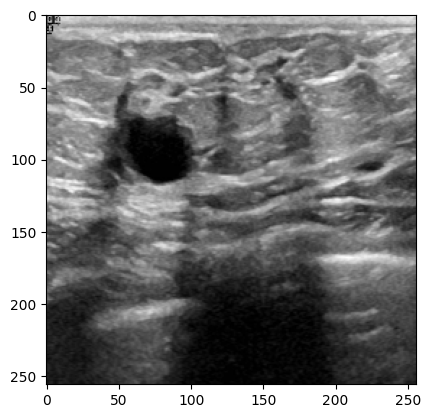

In [15]:
for i, j in train_dataset.take(1):
    plt.imshow(i/255)

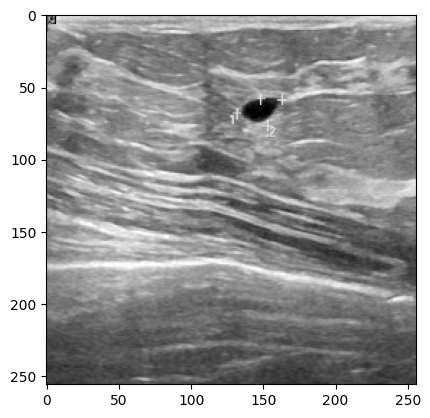

In [16]:
for i, j in val_dataset.take(1):
    plt.imshow(i/255)

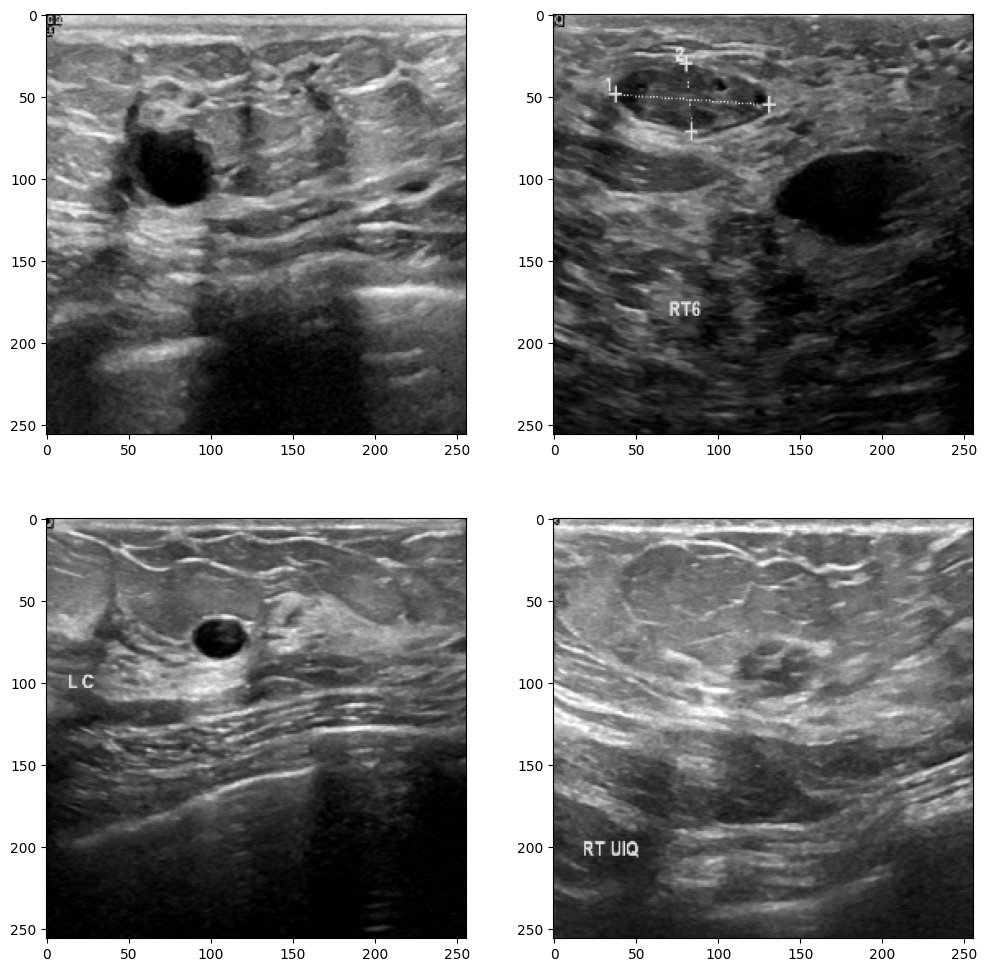

In [17]:
k = 1
plt.figure(figsize=(12, 12))
for i, j in train_dataset.take(4):
    plt.subplot(2, 2, k)
    plt.imshow(i/255)
    k+=1

In [18]:
# val_dataset = tf.keras.utils.image_dataset_from_directory(
#     val_img_path,
#     labels='inferred', # to get label name same as folder name
#     label_mode='categorical',
#     class_names=CLASS_NAMES,
#     color_mode='rgb',
#     batch_size=CONFIGURATION['BATCH_SIZE'],
#     image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
#     shuffle=True,
#     seed=99,     #to have the same shuffle each time
# )

In [19]:
val_dataset

<_MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [20]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [21]:
for data in train_dataset.take(1):
    i, j = data
    print(j.shape)

(3,)


In [22]:
train_dataset = (train_dataset
                 .batch(CONFIGURATION['BATCH_SIZE'])
                 .shuffle(CONFIGURATION['SHUFFLE_SIZE'], reshuffle_each_iteration=True)
                 .prefetch(tf.data.AUTOTUNE))

In [23]:
val_dataset = (val_dataset
               .batch(CONFIGURATION['BATCH_SIZE'])
               .prefetch(tf.data.AUTOTUNE)
               )

In [24]:
test_dataset = (test_dataset
               .batch(CONFIGURATION['BATCH_SIZE'])
               .prefetch(tf.data.AUTOTUNE)
               )

In [25]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [26]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [27]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

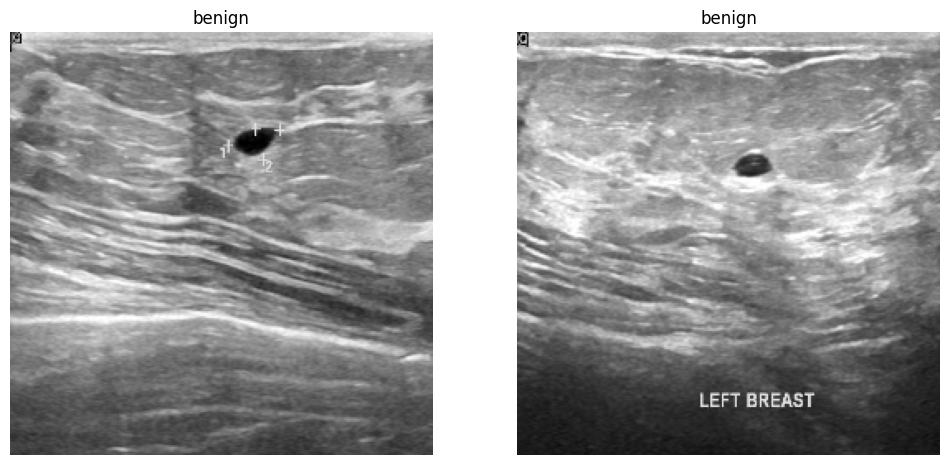

In [28]:
plt.figure(figsize=(12, 12))

for image, label in val_dataset.take(1):
    for i in range(2):
        ax = plt.subplot(1, 2, i+1)
        # print(image[i].shape)
        plt.imshow(image[i]/255)
        plt.title(CLASS_NAMES[tf.argmax(label[i]).numpy()])
        plt.axis("off")

# Data Augmentation

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_img_path,
    labels='inferred', # to get label name same as folder name
    label_mode='categorical',  #label mode two types int, categorical. int means class 0, 1, 2. categorical means one hot encoding
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,     #to have the same shuffle each time
)


Found 714 files belonging to 3 classes.


In [8]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_img_path,
    labels='inferred', # to get label name same as folder name
    label_mode='categorical',  #label mode two types int, categorical. int means class 0, 1, 2. categorical means one hot encoding
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,     #to have the same shuffle each time
)


Found 45 files belonging to 3 classes.


In [9]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_img_path,
    labels='inferred', # to get label name same as folder name
    label_mode='categorical',  #label mode two types int, categorical. int means class 0, 1, 2. categorical means one hot encoding
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=False,
    seed=99,     #to have the same shuffle each time
)


Found 21 files belonging to 3 classes.


In [10]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025, 0.025)),
    RandomFlip(mode='horizontal'),
    # RandomContrast(factor=0.1)
])

In [11]:
@tf.function
def augment_layer(image, label):
    return augment_layers(image, training=True), label

In [7]:
train_dataset = train_dataset.map(augment_layer)

In [8]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [9]:
def augmentation(image, horizontal_flip=0.5, vertical_flip=0.5, random_rotate90=0.5):
    # print('2: ', np.max(new_orig), np.max(new_mask))
    aug = RandomRotate90(p=random_rotate90)
    augment = aug(image=image)
    new_image = augment['image']

    # print('3: ', np.max(new_orig), np.max(new_mask))
    aug = HorizontalFlip(p=horizontal_flip)
    augment = aug(image=new_image)
    new_image = augment['image']

    # print('4: ', np.max(new_orig), np.max(new_mask))
    aug = VerticalFlip(p=vertical_flip)
    augment = aug(image=new_image)
    new_image = augment['image']

    # print('5: ', np.max(new_orig), np.max(new_mask))
    return new_image

In [46]:
def cv_read(image, label):
    img = tf.numpy_function(augmentation, inp=[image], Tout=tf.float32)
    img = tf.reshape(img, shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3))
    return img, label

In [47]:
# train_dataset.map(cv_read)

<_MapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [12]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False,
    weights='imagenet',
    input_shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)
)
backbone.trainable = False

In [13]:
efficient_net_model = tf.keras.Sequential([
    Input(shape=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION['N_DENSE_1'], activation='relu'),
    BatchNormalization(),
    Dense(CONFIGURATION['N_DENSE_2'], activation='relu'),
    Dense(CONFIGURATION['NUM_CLASSES'], activation='softmax')
])

efficient_net_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1836032   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                      

In [17]:
efficient_net_model.compile(
    optimizer = Adam(learning_rate=CONFIGURATION['LEARNING_RATE']/10),
    loss = CategoricalCrossentropy(),
    metrics = CategoricalAccuracy(),
)

model_save = ModelCheckpoint('eff_net_breast.cancer.keras', verbose=1, save_best_only=True, save_weights_only=True)

In [13]:
history = efficient_net_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose=1,
    callbacks = [model_save]
)

Epoch 1/50
90/90 [==============================] - ETA: 0s - loss: 0.8137 - categorical_accuracy: 0.6289
Epoch 1: val_loss improved from inf to 0.87132, saving model to eff_net_breast.cancer.keras
90/90 [==============================] - 76s 729ms/step - loss: 0.8137 - categorical_accuracy: 0.6289 - val_loss: 0.8713 - val_categorical_accuracy: 0.6444
Epoch 2/50
90/90 [==============================] - ETA: 0s - loss: 0.4936 - categorical_accuracy: 0.7899
Epoch 2: val_loss improved from 0.87132 to 0.75711, saving model to eff_net_breast.cancer.keras
90/90 [==============================] - 60s 662ms/step - loss: 0.4936 - categorical_accuracy: 0.7899 - val_loss: 0.7571 - val_categorical_accuracy: 0.5778
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 0.3783 - categorical_accuracy: 0.8585
Epoch 3: val_loss improved from 0.75711 to 0.54098, saving model to eff_net_breast.cancer.keras
90/90 [==============================] - 61s 675ms/step - loss: 0.3783 - categorical_a

KeyboardInterrupt: 

# evaluate

In [18]:
efficient_net_model.load_weights('./eff_net_breast.cancer.keras')

In [19]:
efficient_net_model.evaluate(test_dataset)

3/3 [==============================] - 3s 98ms/step - loss: 0.3327 - categorical_accuracy: 0.8095


[0.33269044756889343, 0.8095238208770752]